# Start

In [1]:
import os
import tensorflow as tf

2025-01-14 17:27:17.107883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736886437.134456 1289583 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736886437.141783 1289583 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 17:27:17.165385: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


I0000 00:00:1736886441.704232 1289583 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3679 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:08:00.0, compute capability: 7.5


# Functions

In [3]:
# Parsing function.
def parse_example(example_proto, input, output):

    def dense_features_process(parsed_features):
        # Parse the example.
        parsed_features = tf.io.parse_single_example(example_proto, parsed_features)

        # Convert SparseTensors to DenseTensors.
        #   This is necessary because we loaded features with variable length.
        #   Although the parsed files have the desired data, they have other things 
        #   (indices, values and dense_shape). Neural networks must work with values
        #   in a more direct way.
        
        dense_features_input = {
            key: tf.sparse.to_dense(value, default_value=0.0)
            if isinstance(value, tf.SparseTensor) else value
            for key, value in parsed_features.items()
        }

        return dense_features_input
    
    parsed_input = dense_features_process(input)
    parsed_output = dense_features_process(output)

    return parsed_input, parsed_output

In [4]:
def read_tfrecord(file, batch_size = 1000):
    # Define feature description for parsing.
    #   Comment every feature that will not be used.
    known_feature_input = {
        # 'NOISY_ALBEDO_B-NIR' : tf.io.VarLenFeature(tf.float32),
        # 'NOISY_ALBEDO_B-UV' : tf.io.VarLenFeature(tf.float32),
        # 'NOISY_ALBEDO_B-Vis' : tf.io.VarLenFeature(tf.float32),

        # 'NOISY_ALBEDO_SS-NIR' : tf.io.VarLenFeature(tf.float32),
        # 'NOISY_ALBEDO_SS-UV' : tf.io.VarLenFeature(tf.float32),
        # 'NOISY_ALBEDO_SS-Vis' : tf.io.VarLenFeature(tf.float32),

        'NOISY_ALBEDO_B-NIR_norm' : tf.io.VarLenFeature(tf.float32),
        'NOISY_ALBEDO_B-UV_norm' : tf.io.VarLenFeature(tf.float32),
        'NOISY_ALBEDO_B-Vis_norm' : tf.io.VarLenFeature(tf.float32),
        
        # 'NOISY_ALBEDO_SS-NIR_norm' : tf.io.VarLenFeature(tf.float32),
        # 'NOISY_ALBEDO_SS-UV_norm' : tf.io.VarLenFeature(tf.float32),
        # 'NOISY_ALBEDO_SS-Vis_norm' : tf.io.VarLenFeature(tf.float32),
    }

    known_feature_output = {
        'radius' : tf.io.FixedLenFeature([], tf.float32),
        'log_gravity' : tf.io.FixedLenFeature([], tf.float32),
        'log_temperature' : tf.io.FixedLenFeature([], tf.float32),
        'log_pressure' : tf.io.FixedLenFeature([], tf.float32),

        # 'OBJECT-DIAMETER' : tf.io.FixedLenFeature([], tf.float32),
        # 'OBJECT-GRAVITY' : tf.io.FixedLenFeature([], tf.float32),
        # 'ATMOSPHERE-TEMPERATURE' : tf.io.FixedLenFeature([], tf.float32),
        # 'ATMOSPHERE-PRESSURE' : tf.io.FixedLenFeature([], tf.float32),
        
        # 'Earth_type' : tf.io.FixedLenFeature([], tf.string),

        'log_C2H6' : tf.io.FixedLenFeature([], tf.float32),
        'log_CH4' : tf.io.FixedLenFeature([], tf.float32),
        'log_CO' : tf.io.FixedLenFeature([], tf.float32),
        'log_CO2' : tf.io.FixedLenFeature([], tf.float32),
        'log_H2O' : tf.io.FixedLenFeature([], tf.float32),
        'log_N2' : tf.io.FixedLenFeature([], tf.float32),
        'log_N2O' : tf.io.FixedLenFeature([], tf.float32),
        'log_O2' : tf.io.FixedLenFeature([], tf.float32),
        'log_O3' : tf.io.FixedLenFeature([], tf.float32)
    }

    # Read TFRecord.
    dataset = tf.data.TFRecordDataset(file)

    parsed_dataset = dataset.map(lambda x: parse_example(x, known_feature_input, known_feature_output), num_parallel_calls=tf.data.AUTOTUNE)

    parsed_dataset = parsed_dataset.batch(batch_size, drop_remainder=False)
    parsed_dataset = parsed_dataset.prefetch(tf.data.AUTOTUNE)
    parsed_dataset = tf.data.Dataset.range(1).interleave(lambda _: parsed_dataset, num_parallel_calls=tf.data.AUTOTUNE)

    return parsed_dataset

# Run

In [5]:
def load_dataset(data_type):
    root_folder = f'TFRecord_data/{data_type}'

    files = os.listdir(root_folder)
    return [os.path.join(root_folder, file) for file in files]

In [6]:
train_ds = read_tfrecord(load_dataset('train'))
val_ds = read_tfrecord(load_dataset('val'))
test_ds = read_tfrecord(load_dataset('test'))

In [21]:
def build_model():
    outputs_list = [
        'radius',
        'log_gravity',
        'log_temperature',
        'log_pressure',
        'log_C2H6',
        'log_CH4',
        'log_CO',
        'log_CO2',
        'log_H2O',
        'log_N2',
        'log_N2O',
        'log_O2',
        'log_O3'
    ]
    
    input_uv = tf.keras.layers.Input(shape = (8,), name='NOISY_ALBEDO_B-UV_norm')
    input_vis = tf.keras.layers.Input(shape = (94,), name='NOISY_ALBEDO_B-Vis_norm')
    input_nir = tf.keras.layers.Input(shape = (49,), name='NOISY_ALBEDO_B-NIR_norm')

    x = tf.keras.layers.Concatenate()([input_uv, input_vis, input_nir])

    # Add a channel dimension to make it compatible with Conv1D
    x = tf.keras.layers.Reshape((151, 1))(x)

    x = tf.keras.layers.Conv1D(48, 5, activation='swish')(x)
    x = tf.keras.layers.Conv1D(48, 5, activation='swish')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv1D(16, 5, activation='swish')(x)
    x = tf.keras.layers.Conv1D(16, 5, activation='swish')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv1D(16, 5, activation='swish')(x)
    x = tf.keras.layers.Conv1D(16, 5, activation='swish')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Flatten()(x)

    z = tf.keras.layers.Dense(384, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    # z = tf.keras.layers.Dropout(0.4)(z)
    z = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(z)
    # z = tf.keras.layers.Dropout(0.4)(z)

    # Output Layers
    outputs = {}
    for output_name in outputs_list:
        output = tf.keras.layers.Dense(
            units=1,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l1(1e-5),
            name=output_name
        )(x)
        outputs[output_name] = output

    losses = {output_name: 'mse' for output_name in outputs_list}

    inpts = [input_uv, input_vis, input_nir]

    # Define the optimizer with the specified parameters
    learning_rate = 1e-3  # equivalent to 10^-5
    beta_1 = 0.9
    beta_2 = 0.999
    epsilon = 1e-5  # equivalent to 10^-8

    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

    model = tf.keras.Model(inputs=inpts, outputs=outputs, name="teste_1")
    model.compile(optimizer=opt, loss=losses)

    return model

In [22]:
with strategy.scope():
  model = build_model()

  epochs = 10
  hist = model.fit(train_ds,
                  epochs=epochs,
                  validation_data=val_ds
                  )

2025-01-14 17:42:40.617456: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144


Epoch 1/10


I0000 00:00:1736887363.807999 1289873 cuda_dnn.cc:529] Loaded cuDNN version 90600


      1/Unknown 5s 5s/step - log_C2H6_loss: 1.7381 - log_CH4_loss: 1.2328 - log_CO2_loss: 0.3160 - log_CO_loss: 2.1843 - log_H2O_loss: 0.0810 - log_N2O_loss: 1.2223 - log_N2_loss: 0.6394 - log_O2_loss: 3.7824 - log_O3_loss: 0.1363 - log_gravity_loss: 3.2109 - log_pressure_loss: 39.0844 - log_temperature_loss: 27.3473 - loss: 82.5863 - radius_loss: 1.6088

2025-01-14 17:42:45.546434: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.99GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-14 17:42:45.571201: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.95GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


    554/Unknown 24s 35ms/step - log_C2H6_loss: 0.1558 - log_CH4_loss: 0.0646 - log_CO2_loss: 0.0340 - log_CO_loss: 0.1228 - log_H2O_loss: 0.0415 - log_N2O_loss: 0.1028 - log_N2_loss: 0.2515 - log_O2_loss: 0.1675 - log_O3_loss: 0.0875 - log_gravity_loss: 0.5957 - log_pressure_loss: 5.0842 - log_temperature_loss: 4.1660 - loss: 11.1875 - radius_loss: 0.3116

2025-01-14 17:43:05.039288: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-14 17:43:05.039393: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


    555/Unknown 24s 35ms/step - log_C2H6_loss: 0.1556 - log_CH4_loss: 0.0645 - log_CO2_loss: 0.0340 - log_CO_loss: 0.1226 - log_H2O_loss: 0.0415 - log_N2O_loss: 0.1026 - log_N2_loss: 0.2513 - log_O2_loss: 0.1673 - log_O3_loss: 0.0874 - log_gravity_loss: 0.5951 - log_pressure_loss: 5.0780 - log_temperature_loss: 4.1607 - loss: 11.1739 - radius_loss: 0.3113

2025-01-14 17:43:05.276462: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-14 17:43:05.356512: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16849946761897844930
2025-01-14 17:43:05.356548: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 13176702537745137392
2025-01-14 17:43:05.356560: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16882785552957409560
2025-01-14 17:43:05.356569: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 9088234436679659244
2025-01-14 17:43:05.356578: I tensorflow/core/framework/local_rendezvous.cc:428] Local

555/555 ━━━━━━━━━━━━━━━━━━━━ 32s 49ms/step - log_C2H6_loss: 0.1554 - log_CH4_loss: 0.0644 - log_CO2_loss: 0.0339 - log_CO_loss: 0.1224 - log_H2O_loss: 0.0414 - log_N2O_loss: 0.1025 - log_N2_loss: 0.2511 - log_O2_loss: 0.1672 - log_O3_loss: 0.0873 - log_gravity_loss: 0.5944 - log_pressure_loss: 5.0718 - log_temperature_loss: 4.1554 - loss: 11.1603 - radius_loss: 0.3110 - val_log_C2H6_loss: 2.4813e-07 - val_log_CH4_loss: 3.4220e-04 - val_log_CO2_loss: 0.0074 - val_log_CO_loss: 1.1448e-04 - val_log_H2O_loss: 7.2356e-04 - val_log_N2O_loss: 2.6136e-10 - val_log_N2_loss: 0.0497 - val_log_O2_loss: 0.0580 - val_log_O3_loss: 1.1648e-06 - val_log_gravity_loss: 0.0865 - val_log_pressure_loss: 0.4750 - val_log_temperature_loss: 0.0962 - val_loss: 0.8044 - val_radius_loss: 0.0247
Epoch 2/10
  1/555 ━━━━━━━━━━━━━━━━━━━━ 1:07 123ms/step - log_C2H6_loss: 2.7556e-05 - log_CH4_loss: 5.3952e-04 - log_CO2_loss: 0.0095 - log_CO_loss: 4.5170e-06 - log_H2O_loss: 0.0022 - log_N2O_loss: 5.4886e-15 - log_N2_los

2025-01-14 17:43:12.959324: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_41005}}{{node cond/IteratorGetNext}}]]


554/555 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - log_C2H6_loss: 2.8548e-04 - log_CH4_loss: 3.6005e-04 - log_CO2_loss: 0.0076 - log_CO_loss: 1.7182e-04 - log_H2O_loss: 7.6463e-04 - log_N2O_loss: 2.0253e-05 - log_N2_loss: 0.0402 - log_O2_loss: 0.0329 - log_O3_loss: 6.2082e-05 - log_gravity_loss: 0.0602 - log_pressure_loss: 0.2515 - log_temperature_loss: 0.0758 - loss: 0.4966 - radius_loss: 0.0248

2025-01-14 17:43:33.165137: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16849946761897844930
2025-01-14 17:43:33.165193: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 13176702537745137392
2025-01-14 17:43:33.165206: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16882785552957409560
2025-01-14 17:43:33.165217: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 9088234436679659244
2025-01-14 17:43:33.165228: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14942566517002809100
2025-01-14 17:43:33.165238: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 10319556255195323012
2025-01-14 17:43:33.165250: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous sen

555/555 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - log_C2H6_loss: 2.8525e-04 - log_CH4_loss: 3.6002e-04 - log_CO2_loss: 0.0076 - log_CO_loss: 1.7177e-04 - log_H2O_loss: 7.6452e-04 - log_N2O_loss: 2.0239e-05 - log_N2_loss: 0.0402 - log_O2_loss: 0.0329 - log_O3_loss: 6.2042e-05 - log_gravity_loss: 0.0602 - log_pressure_loss: 0.2514 - log_temperature_loss: 0.0758 - loss: 0.4965 - radius_loss: 0.0248 - val_log_C2H6_loss: 6.1613e-05 - val_log_CH4_loss: 3.5261e-04 - val_log_CO2_loss: 0.0074 - val_log_CO_loss: 2.2243e-04 - val_log_H2O_loss: 7.2569e-04 - val_log_N2O_loss: 2.9272e-06 - val_log_N2_loss: 0.0339 - val_log_O2_loss: 0.0276 - val_log_O3_loss: 1.9222e-06 - val_log_gravity_loss: 0.0506 - val_log_pressure_loss: 0.2133 - val_log_temperature_loss: 0.0402 - val_loss: 0.3967 - val_radius_loss: 0.0186
Epoch 3/10
  1/555 ━━━━━━━━━━━━━━━━━━━━ 1:20 146ms/step - log_C2H6_loss: 0.0000e+00 - log_CH4_loss: 5.3952e-04 - log_CO2_loss: 0.0095 - log_CO_loss: 4.2259e-07 - log_H2O_loss: 0.0022 - log_N2O_loss: 

2025-01-14 17:43:39.330423: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_41005}}{{node cond/IteratorGetNext}}]]


554/555 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - log_C2H6_loss: 8.8719e-05 - log_CH4_loss: 3.4240e-04 - log_CO2_loss: 0.0076 - log_CO_loss: 1.3973e-04 - log_H2O_loss: 7.4542e-04 - log_N2O_loss: 6.8367e-06 - log_N2_loss: 0.0324 - log_O2_loss: 0.0253 - log_O3_loss: 1.8106e-05 - log_gravity_loss: 0.0503 - log_pressure_loss: 0.2025 - log_temperature_loss: 0.0364 - loss: 0.3761 - radius_loss: 0.0183

2025-01-14 17:43:59.584267: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16849946761897844930
2025-01-14 17:43:59.584314: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 13176702537745137392
2025-01-14 17:43:59.584326: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16882785552957409560
2025-01-14 17:43:59.584335: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 9088234436679659244
2025-01-14 17:43:59.584343: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14942566517002809100
2025-01-14 17:43:59.584353: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 10319556255195323012
2025-01-14 17:43:59.584361: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous sen

555/555 ━━━━━━━━━━━━━━━━━━━━ 27s 48ms/step - log_C2H6_loss: 8.8664e-05 - log_CH4_loss: 3.4239e-04 - log_CO2_loss: 0.0076 - log_CO_loss: 1.3971e-04 - log_H2O_loss: 7.4533e-04 - log_N2O_loss: 6.8343e-06 - log_N2_loss: 0.0324 - log_O2_loss: 0.0253 - log_O3_loss: 1.8098e-05 - log_gravity_loss: 0.0503 - log_pressure_loss: 0.2025 - log_temperature_loss: 0.0364 - loss: 0.3760 - radius_loss: 0.0183 - val_log_C2H6_loss: 2.3761e-05 - val_log_CH4_loss: 3.4512e-04 - val_log_CO2_loss: 0.0074 - val_log_CO_loss: 1.8388e-04 - val_log_H2O_loss: 7.2508e-04 - val_log_N2O_loss: 9.0892e-07 - val_log_N2_loss: 0.0314 - val_log_O2_loss: 0.0245 - val_log_O3_loss: 7.8288e-07 - val_log_gravity_loss: 0.0463 - val_log_pressure_loss: 0.1897 - val_log_temperature_loss: 0.0250 - val_loss: 0.3458 - val_radius_loss: 0.0167
Epoch 4/10
554/555 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - log_C2H6_loss: 3.1555e-05 - log_CH4_loss: 3.4047e-04 - log_CO2_loss: 0.0076 - log_CO_loss: 1.2795e-04 - log_H2O_loss: 7.4129e-04 - log_N2O_loss:

2025-01-14 17:44:26.421054: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16849946761897844930
2025-01-14 17:44:26.421093: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 13176702537745137392
2025-01-14 17:44:26.421101: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16882785552957409560
2025-01-14 17:44:26.421108: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 9088234436679659244
2025-01-14 17:44:26.421122: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14942566517002809100
2025-01-14 17:44:26.421129: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 10319556255195323012
2025-01-14 17:44:26.421135: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous sen

555/555 ━━━━━━━━━━━━━━━━━━━━ 27s 48ms/step - log_C2H6_loss: 3.1537e-05 - log_CH4_loss: 3.4046e-04 - log_CO2_loss: 0.0076 - log_CO_loss: 1.2793e-04 - log_H2O_loss: 7.4120e-04 - log_N2O_loss: 4.4697e-06 - log_N2_loss: 0.0298 - log_O2_loss: 0.0231 - log_O3_loss: 5.7596e-06 - log_gravity_loss: 0.0466 - log_pressure_loss: 0.1846 - log_temperature_loss: 0.0244 - loss: 0.3356 - radius_loss: 0.0164 - val_log_C2H6_loss: 1.1353e-05 - val_log_CH4_loss: 3.4235e-04 - val_log_CO2_loss: 0.0074 - val_log_CO_loss: 1.4685e-04 - val_log_H2O_loss: 7.2505e-04 - val_log_N2O_loss: 3.2621e-07 - val_log_N2_loss: 0.0305 - val_log_O2_loss: 0.0228 - val_log_O3_loss: 6.4964e-07 - val_log_gravity_loss: 0.0450 - val_log_pressure_loss: 0.1751 - val_log_temperature_loss: 0.0187 - val_loss: 0.3194 - val_radius_loss: 0.0154
Epoch 5/10
  1/555 ━━━━━━━━━━━━━━━━━━━━ 1:22 148ms/step - log_C2H6_loss: 0.0000e+00 - log_CH4_loss: 5.3952e-04 - log_CO2_loss: 0.0095 - log_CO_loss: 4.5975e-08 - log_H2O_loss: 0.0022 - log_N2O_loss: 

2025-01-14 17:44:32.920038: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_41005}}{{node cond/IteratorGetNext}}]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - log_C2H6_loss: 1.1754e-05 - log_CH4_loss: 3.3877e-04 - log_CO2_loss: 0.0075 - log_CO_loss: 1.1932e-04 - log_H2O_loss: 7.4010e-04 - log_N2O_loss: 2.7064e-06 - log_N2_loss: 0.0286 - log_O2_loss: 0.0214 - log_O3_loss: 3.3720e-06 - log_gravity_loss: 0.0445 - log_pressure_loss: 0.1749 - log_temperature_loss: 0.0190 - loss: 0.3144 - radius_loss: 0.0154

2025-01-14 17:44:53.409483: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16849946761897844930
2025-01-14 17:44:53.409540: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 13176702537745137392
2025-01-14 17:44:53.409551: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16882785552957409560
2025-01-14 17:44:53.409561: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 9088234436679659244
2025-01-14 17:44:53.409569: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14942566517002809100
2025-01-14 17:44:53.409578: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 10319556255195323012
2025-01-14 17:44:53.409587: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous sen

555/555 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - log_C2H6_loss: 1.1751e-05 - log_CH4_loss: 3.3876e-04 - log_CO2_loss: 0.0075 - log_CO_loss: 1.1931e-04 - log_H2O_loss: 7.4005e-04 - log_N2O_loss: 2.7066e-06 - log_N2_loss: 0.0286 - log_O2_loss: 0.0214 - log_O3_loss: 3.3743e-06 - log_gravity_loss: 0.0445 - log_pressure_loss: 0.1749 - log_temperature_loss: 0.0190 - loss: 0.3144 - radius_loss: 0.0154 - val_log_C2H6_loss: 3.6250e-06 - val_log_CH4_loss: 3.3999e-04 - val_log_CO2_loss: 0.0074 - val_log_CO_loss: 1.2853e-04 - val_log_H2O_loss: 7.2468e-04 - val_log_N2O_loss: 1.7288e-07 - val_log_N2_loss: 0.0295 - val_log_O2_loss: 0.0216 - val_log_O3_loss: 4.5501e-07 - val_log_gravity_loss: 0.0440 - val_log_pressure_loss: 0.1668 - val_log_temperature_loss: 0.0136 - val_loss: 0.3022 - val_radius_loss: 0.0149
Epoch 6/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - log_C2H6_loss: 3.9928e-06 - log_CH4_loss: 3.3773e-04 - log_CO2_loss: 0.0075 - log_CO_loss: 1.1543e-04 - log_H2O_loss: 7.3967e-04 - log_N2O_loss:

2025-01-14 17:45:21.347899: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16849946761897844930
2025-01-14 17:45:21.347943: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 13176702537745137392
2025-01-14 17:45:21.347953: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16882785552957409560
2025-01-14 17:45:21.347962: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 9088234436679659244
2025-01-14 17:45:21.347970: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14942566517002809100
2025-01-14 17:45:21.347979: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 10319556255195323012
2025-01-14 17:45:21.347987: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous sen

555/555 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - log_C2H6_loss: 3.9927e-06 - log_CH4_loss: 3.3772e-04 - log_CO2_loss: 0.0075 - log_CO_loss: 1.1543e-04 - log_H2O_loss: 7.3962e-04 - log_N2O_loss: 2.1498e-06 - log_N2_loss: 0.0277 - log_O2_loss: 0.0205 - log_O3_loss: 2.6872e-06 - log_gravity_loss: 0.0430 - log_pressure_loss: 0.1689 - log_temperature_loss: 0.0159 - loss: 0.3015 - radius_loss: 0.0149 - val_log_C2H6_loss: 1.2017e-06 - val_log_CH4_loss: 3.3992e-04 - val_log_CO2_loss: 0.0074 - val_log_CO_loss: 1.1985e-04 - val_log_H2O_loss: 7.2462e-04 - val_log_N2O_loss: 6.0596e-07 - val_log_N2_loss: 0.0286 - val_log_O2_loss: 0.0211 - val_log_O3_loss: 4.6773e-07 - val_log_gravity_loss: 0.0429 - val_log_pressure_loss: 0.1637 - val_log_temperature_loss: 0.0110 - val_loss: 0.2939 - val_radius_loss: 0.0149
Epoch 7/10
554/555 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - log_C2H6_loss: 1.4071e-06 - log_CH4_loss: 3.3789e-04 - log_CO2_loss: 0.0075 - log_CO_loss: 1.1338e-04 - log_H2O_loss: 7.3962e-04 - log_N2O_loss:

2025-01-14 17:45:49.306059: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16849946761897844930
2025-01-14 17:45:49.306129: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 13176702537745137392
2025-01-14 17:45:49.306144: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16882785552957409560
2025-01-14 17:45:49.306156: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 9088234436679659244
2025-01-14 17:45:49.306167: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14942566517002809100
2025-01-14 17:45:49.306177: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 10319556255195323012
2025-01-14 17:45:49.306186: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous sen

555/555 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - log_C2H6_loss: 1.4079e-06 - log_CH4_loss: 3.3787e-04 - log_CO2_loss: 0.0075 - log_CO_loss: 1.1338e-04 - log_H2O_loss: 7.3953e-04 - log_N2O_loss: 2.0046e-06 - log_N2_loss: 0.0270 - log_O2_loss: 0.0199 - log_O3_loss: 1.6150e-06 - log_gravity_loss: 0.0419 - log_pressure_loss: 0.1645 - log_temperature_loss: 0.0137 - loss: 0.2923 - radius_loss: 0.0147 - val_log_C2H6_loss: 4.4794e-08 - val_log_CH4_loss: 3.3965e-04 - val_log_CO2_loss: 0.0074 - val_log_CO_loss: 1.1522e-04 - val_log_H2O_loss: 7.2458e-04 - val_log_N2O_loss: 4.1395e-07 - val_log_N2_loss: 0.0284 - val_log_O2_loss: 0.0211 - val_log_O3_loss: 8.7156e-07 - val_log_gravity_loss: 0.0431 - val_log_pressure_loss: 0.1637 - val_log_temperature_loss: 0.0098 - val_loss: 0.2930 - val_radius_loss: 0.0152
Epoch 8/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - log_C2H6_loss: 4.8201e-07 - log_CH4_loss: 3.3817e-04 - log_CO2_loss: 0.0075 - log_CO_loss: 1.1221e-04 - log_H2O_loss: 7.3954e-04 - log_N2O_loss:

2025-01-14 17:46:17.745819: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16849946761897844930
2025-01-14 17:46:17.745863: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 13176702537745137392
2025-01-14 17:46:17.745876: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16882785552957409560
2025-01-14 17:46:17.745888: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 9088234436679659244
2025-01-14 17:46:17.745900: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14942566517002809100
2025-01-14 17:46:17.745911: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 10319556255195323012
2025-01-14 17:46:17.745923: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous sen

555/555 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - log_C2H6_loss: 4.8264e-07 - log_CH4_loss: 3.3816e-04 - log_CO2_loss: 0.0075 - log_CO_loss: 1.1221e-04 - log_H2O_loss: 7.3950e-04 - log_N2O_loss: 1.4123e-06 - log_N2_loss: 0.0264 - log_O2_loss: 0.0199 - log_O3_loss: 7.2235e-07 - log_gravity_loss: 0.0410 - log_pressure_loss: 0.1607 - log_temperature_loss: 0.0120 - loss: 0.2849 - radius_loss: 0.0144 - val_log_C2H6_loss: 4.4238e-11 - val_log_CH4_loss: 3.3943e-04 - val_log_CO2_loss: 0.0074 - val_log_CO_loss: 1.1457e-04 - val_log_H2O_loss: 7.2457e-04 - val_log_N2O_loss: 2.1931e-07 - val_log_N2_loss: 0.0282 - val_log_O2_loss: 0.0208 - val_log_O3_loss: 1.4654e-06 - val_log_gravity_loss: 0.0434 - val_log_pressure_loss: 0.1665 - val_log_temperature_loss: 0.0094 - val_loss: 0.2958 - val_radius_loss: 0.0158
Epoch 9/10
  1/555 ━━━━━━━━━━━━━━━━━━━━ 1:19 143ms/step - log_C2H6_loss: 0.0000e+00 - log_CH4_loss: 5.3952e-04 - log_CO2_loss: 0.0095 - log_CO_loss: 4.5975e-08 - log_H2O_loss: 0.0022 - log_N2O_loss: 

2025-01-14 17:46:24.927093: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_41005}}{{node cond/IteratorGetNext}}]]


554/555 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - log_C2H6_loss: 2.0156e-07 - log_CH4_loss: 3.3792e-04 - log_CO2_loss: 0.0075 - log_CO_loss: 1.1153e-04 - log_H2O_loss: 7.3957e-04 - log_N2O_loss: 8.9355e-07 - log_N2_loss: 0.0260 - log_O2_loss: 0.0195 - log_O3_loss: 3.0595e-07 - log_gravity_loss: 0.0400 - log_pressure_loss: 0.1570 - log_temperature_loss: 0.0106 - loss: 0.2777 - radius_loss: 0.0141

2025-01-14 17:46:46.436546: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16849946761897844930
2025-01-14 17:46:46.436598: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 13176702537745137392
2025-01-14 17:46:46.436611: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16882785552957409560
2025-01-14 17:46:46.436622: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 9088234436679659244
2025-01-14 17:46:46.436632: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14942566517002809100
2025-01-14 17:46:46.436643: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 10319556255195323012
2025-01-14 17:46:46.436654: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous sen

555/555 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - log_C2H6_loss: 2.0301e-07 - log_CH4_loss: 3.3790e-04 - log_CO2_loss: 0.0075 - log_CO_loss: 1.1154e-04 - log_H2O_loss: 7.3949e-04 - log_N2O_loss: 8.9402e-07 - log_N2_loss: 0.0260 - log_O2_loss: 0.0195 - log_O3_loss: 3.0705e-07 - log_gravity_loss: 0.0400 - log_pressure_loss: 0.1570 - log_temperature_loss: 0.0106 - loss: 0.2777 - radius_loss: 0.0141 - val_log_C2H6_loss: 4.4238e-11 - val_log_CH4_loss: 3.3951e-04 - val_log_CO2_loss: 0.0074 - val_log_CO_loss: 1.1454e-04 - val_log_H2O_loss: 7.2457e-04 - val_log_N2O_loss: 2.1996e-07 - val_log_N2_loss: 0.0276 - val_log_O2_loss: 0.0216 - val_log_O3_loss: 7.6491e-07 - val_log_gravity_loss: 0.0452 - val_log_pressure_loss: 0.1712 - val_log_temperature_loss: 0.0090 - val_loss: 0.3030 - val_radius_loss: 0.0166
Epoch 10/10
554/555 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - log_C2H6_loss: 2.5809e-07 - log_CH4_loss: 3.3772e-04 - log_CO2_loss: 0.0075 - log_CO_loss: 1.1131e-04 - log_H2O_loss: 7.3957e-04 - log_N2O_loss

2025-01-14 17:47:15.358468: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16849946761897844930
2025-01-14 17:47:15.358521: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 13176702537745137392
2025-01-14 17:47:15.358532: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16882785552957409560
2025-01-14 17:47:15.358542: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 9088234436679659244
2025-01-14 17:47:15.358551: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14942566517002809100
2025-01-14 17:47:15.358560: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 10319556255195323012
2025-01-14 17:47:15.358568: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous sen

555/555 ━━━━━━━━━━━━━━━━━━━━ 29s 53ms/step - log_C2H6_loss: 2.5874e-07 - log_CH4_loss: 3.3770e-04 - log_CO2_loss: 0.0075 - log_CO_loss: 1.1131e-04 - log_H2O_loss: 7.3948e-04 - log_N2O_loss: 5.2129e-07 - log_N2_loss: 0.0257 - log_O2_loss: 0.0196 - log_O3_loss: 1.6926e-07 - log_gravity_loss: 0.0396 - log_pressure_loss: 0.1549 - log_temperature_loss: 0.0097 - loss: 0.2740 - radius_loss: 0.0140 - val_log_C2H6_loss: 4.4238e-11 - val_log_CH4_loss: 3.3898e-04 - val_log_CO2_loss: 0.0074 - val_log_CO_loss: 1.1451e-04 - val_log_H2O_loss: 7.2457e-04 - val_log_N2O_loss: 1.2336e-07 - val_log_N2_loss: 0.0277 - val_log_O2_loss: 0.0221 - val_log_O3_loss: 5.4037e-07 - val_log_gravity_loss: 0.0505 - val_log_pressure_loss: 0.1868 - val_log_temperature_loss: 0.0092 - val_loss: 0.3274 - val_radius_loss: 0.0192


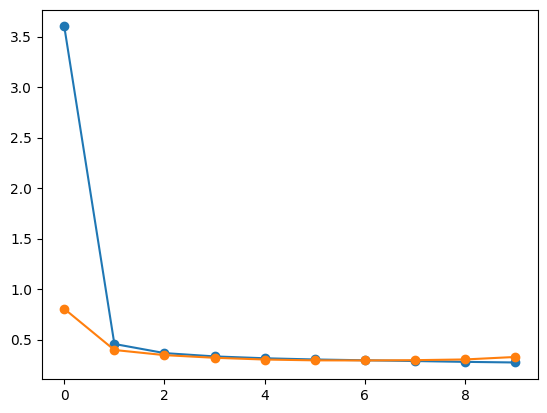

In [32]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), hist.history["loss"], marker="o")
plt.plot(range(epochs), hist.history["val_loss"], marker="o")